In [101]:
from datagenerator import DataGen
import numpy as np
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

tf.enable_eager_execution()

In [2]:
def chi_sq_dist(X):
    X_1 = tf.expand_dims(X, 1)
    X_2 = tf.expand_dims(X, 0)

    epsilon = tf.constant(0.000001)
    
    return 0.5 * tf.reduce_sum(tf.squared_difference(X_1, X_2) / (X_1+X_2 + epsilon), 2)

In [6]:
X, y = DataGen.circle(100, 0)

N = X.shape[0]
dims = X.shape[1]
K = 4

'\nknc0 = KNeighborsClassifier(n_neighbors=K)\nknc1 = KNeighborsClassifier(n_neighbors=K)\nknc0.fit(X[y==0], y[y==0])\nknc1.fit(X[y==1], y[y==1])\n\nnn = knc0.kneighbors(X[y==0],K,return_distance=False)\nim = knc1.kneighbors(X[y==0],K,return_distance=False)+50\n'

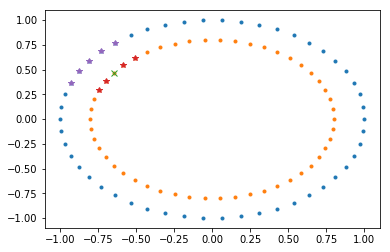

In [136]:
knc = KNeighborsClassifier(n_neighbors=N)
knc.fit(X, y)


nearest_points = knc.kneighbors(X, N, return_distance= False)
#impostors = knc.kneighbors(X, N, return_distance= False)

Mi = np.sum(y==1)
im = np.zeros((N,K+1))
for i in range(Mi):
    tmp = nearest_points[i,:]
    yo = tmp[y[tmp]==1][:K+1]
    im[i,:] = yo
for i in range(Mi,N):
    tmp = nearest_points[i,:]
    yo = tmp[y[tmp]==0][:K+1]
    im[i,:] = yo
    
    
Mn = np.sum(y==0)
nn = np.zeros((N,K+1))
for i in range(Mn):
    tmp = nearest_points[i,:]
    yo = tmp[y[tmp]==0][:K+1]
    nn[i,:] = yo
for i in range(Mn,N):
    tmp = nearest_points[i,:]
    yo = tmp[y[tmp]==1][:K+1]
    nn[i,:] = yo
    
#print(nn)
#print(nearest_points)
#mp = nearest_points[10,:]
#print(tmp)
#print(y[tmp])
#print(tmp[y[tmp]==1])


t = 70

plt.plot(X[y==0, 0], X[y==0, 1],'.')
plt.plot(X[y==1, 0], X[y==1, 1],'.')
plt.plot(X[int(nn[t,0]),0],X[int(nn[t,0]),1],'x')
plt.plot(X[nn[t,1:].astype(np.int),0],X[nn[t,1:].astype(np.int),1],'*')
plt.plot(X[im[t,:].astype(np.int),0],X[im[t,:].astype(np.int),1],'*')


'''
knc0 = KNeighborsClassifier(n_neighbors=K)
knc1 = KNeighborsClassifier(n_neighbors=K)
knc0.fit(X[y==0], y[y==0])
knc1.fit(X[y==1], y[y==1])

nn = knc0.kneighbors(X[y==0],K,return_distance=False)
im = knc1.kneighbors(X[y==0],K,return_distance=False)+50
'''



In [ ]:
X = tf.Variable(X, dtype=tf.float32)

target_neighbours = tf.zeros((N, K)) #TODO!
impostors = tf.zeros((N, K)) #TODO!

A = 10 * tf.eye(dims) + 0.01 * tf.ones((dims,dims))
L = tf.math.softmax(A, axis=0)

chi_dist = chi_sq_dist(L @ X)


In [96]:
X = tf.cast(X, tf.float32)
chi_dist =  chi_sq_dist(X)


<tf.Tensor: id=971, shape=(4, 4), dtype=float32, numpy=
array([[ 0.       ,  3.5714283, 38.20707  ,  9.533333 ],
       [ 3.5714283,  0.       , 48.13887  ,  4.270175 ],
       [38.20707  , 48.13887  ,  0.       , 53.180557 ],
       [ 9.533333 ,  4.270175 , 53.180557 ,  0.       ]], dtype=float32)>

<tf.Tensor: id=364, shape=(3,), dtype=int64, numpy=array([17, 13, 41])>

In [44]:
from sklearn.metrics.pairwise import additive_chi2_kernel

In [46]:
additive_chi2_kernel(X)

ValueError: setting an array element with a sequence.

In [45]:

with tf.GradientTape() as tape:
    loss = -0.5 * additive_chi2_kernel(X)

tape.gradient(loss, X)

ValueError: setting an array element with a sequence.

In [5]:
tf.matmul(X,y)

InvalidArgumentError: In[1] is not a matrix. Instead it has shape [2] [Op:MatMul] name: MatMul/